# Extraction des données quotidiennes de températures d'ECCC
## Objectifs:

L'objectif de ce produit est d'extraire les données quotidiennes de températures depuis le jeu de données homogénéisées de seconde génération d'Environnement et Changement Climatique Canada développé par Vincent and al. 2012

Les données climatiques canadiennes ajustées et homogénéisées (DCCAH) ont été créées pour être utilisées dans les recherches climatiques en incluant les études des changements climatiques. Elles incluent un nombre d’ajustements aux données originales des stations pour traiter les sauts causés par les changements d’instruments et de procédures d’observations. Quelques fois les observations de plusieurs stations ont été combinées pour générer de longues séries temporelles.

Les données quotidiennes homogénéisées des températures maximales, minimales et moyennes and les données quotidiennes ajustées des chutes de pluie, de neige et de précipitation totale sont disponibles au ftp://ccrp.tor.ec.gc.ca/pub/EC_data/AHCCD_daily/.

Les observations originales du Service Météorologique de Canada sont disponibles sur http://climate.weather.gc.ca/historical_data/search_historic_data_f.html.

Dans notre étude nous allons détecter la station la plus proche d'une latitude et longitude données: 

La fonction suivante, perment de filtrer les données de la liste de stations Adj_Precipitation_Stations.xls.
En fonctions de critères lati loni yeari et yearf, le code va chercher les données de la station et ensuite nettoyer les données pour les formater quotidiennement. 

In [96]:
def get_closed_station_precip(lati, loni, yeari, yearf):
    
     import pandas as pd
     import os 
     import calendar
     import numpy as np
     from datetime import date
     
     dataframe = pd.read_excel("K:/DATA/Donnees_Stations/2nd_generation_V2018/Adj_Precipitation_Stations.xls", skiprows = range(0, 3))
     dataframe_2 =  dataframe.loc[(dataframe["année déb."] <= yeari) & (dataframe["année fin."] >= yearf),:]
     dataframe_2 = dataframe_2.reset_index(drop=True)
     lats = dataframe_2['lat (deg)']
     lons = dataframe_2['long (deg)']
     dist_sq = (lats-lati)**2 + (lons-loni)**2 
     # 1D index of minimum dist_sq element
     minindex = dist_sq.idxmin() 
     print(dist_sq.idxmin())
     stnid = dataframe_2.iloc[minindex]['stnid'] 
     df_station =  pd.DataFrame(dataframe_2.iloc[minindex]) 
     f1 = open('K:/DATA/Donnees_Stations/2nd_generation_V2018/Adj_Daily_Total_v2017/dt'+str(stnid).replace(' ', '')+'.txt', 'r')
     f2 = open('./tmp.txt', 'w')
    
    ### nettoyage des données: Suppression des Caractères   
     for line in f1:
            for word in line:
                if word == 'M':
                    f2.write(word.replace('M', ' '))
                elif word == 'a':
                    f2.write(word.replace('a', ' '))  
                elif word == 'Z':
                    f2.write(word.replace('Z', ' '))   
                elif word == 'Z':
                    f2.write(word.replace('X', ' '))   
                elif word == 'T':
                    f2.write(word.replace('T', ' '))  
                elif word == 'Y':
                    f2.write(word.replace('Y', ' ')) 
                elif word == 'X':
                    f2.write(word.replace('X', ' '))     
                else:
                    f2.write(word)
     f1.close()
     f2.close()
              
     station = pd.read_csv('./tmp.txt', delim_whitespace=True, skiprows = range(0, 1))
       
     station.columns = ['Annee', 'Mois', 'D1','D2','D3','D4','D5','D6','D7','D8','D9','D10',
                                      'D11','D12','D13','D14','D15','D16','D17','D18','D19','D20',
                                      'D21','D22','D23','D24','D25','D26','D27','D28','D29','D30','D31']
         
     os.remove("./tmp.txt")
       
       # nettoyage des valeurs manquantes 
     try:  
           station = station.replace({'E':''}, regex=True)
     except:
           pass
     try: 
           station = station.replace({'a':''}, regex=True)
     except:
           pass
     try:     
           station = station.replace({'-9999.9':''}, regex=True)
     except:
           pass
     try:     
           station = station.replace({'-9999.99':''}, regex=True)
     except:
           pass   
     try:     
           station = station.replace({-9999.9:''}, regex=True)
     except:
           pass 
     try:     
           station = station.replace({-9999.99:''}, regex=True)
     except:
           pass    
           
     for col in  station.columns[2:]:
           station[col] = pd.to_numeric(station[col], errors='coerce')
           
     m_start =  station['Mois'].loc[(station['Annee'] == yeari)].min()
     m_end   =  station['Mois'].loc[(station['Annee'] == yearf)].max()
       
     d_end = calendar.monthrange(yearf, m_end)[1]
       
    ####################################Extraction des données quotidiennes  et ajout d'une colonne Date      
     tmp_tmin = [ ] 
     for year in range(yeari, yearf+1):    ### Boucle sur les annees
           for month in range(1,13):
               df = []
               last_day = calendar.monthrange(year, month)[1] 
               tmin = station.loc[(station["Annee"] == year) & (station["Mois"] == month)].iloc[:,2:last_day+2].values
               
               if len(tmin) == 0:
                   a = np.empty((calendar.monthrange(year,month)[1]))
                   a[:] = np.nan
                   df=pd.DataFrame(a)
               else:
                   df=pd.DataFrame(tmin.T)
                   
               start = date(year, month, 1)
               end =   date(year, month, last_day)
               delta=(end-start) 
               nb_days = delta.days + 1 
               rng = pd.date_range(start, periods=nb_days, freq='D')          
               df['datetime'] = rng
               df.index = df['datetime']
               tmp_tmin.append(df)
               
     tmp_tmin = pd.concat(tmp_tmin) 
     df = pd.DataFrame({'datetime': tmp_tmin['datetime'], 'variable': tmp_tmin.iloc[:,0]}, columns = ['datetime','variable']) 
     df.index = df['datetime']
     df = df.drop(["datetime"], axis=1)
     
     
     return df, df_station

La fonction suivante permet de cartographier les points de grilles qui seront extraits.

In [97]:
def plot_closed_points(*args):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pylab as plt
    import numpy as np  
  
    lats = args[0]
    lons = args[1]  
    names = args[2]
    var = args[3]
    colors=['black','red','blue', 'green']
    
    fig = plt.figure(figsize=(28,16))   
    ax = plt.axes(projection=ccrs.PlateCarree())    
    ax.set_extent((lons[0] - 3, lons[0] + 3, lats[0] - 3, lats[0] + 3)) 
       
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
    ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
    ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
    
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières      
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière 
                        facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
    
    ax.add_feature(states_provinces, edgecolor='gray')     
    ax.gridlines() 
    i = 0     
    for name in names:         
        ax.scatter(lons[i], lats[i], c= colors[i], s=100, label=name)
        print(lats[i])
        print(lons[i])
        i += 1       
    plt.legend(loc="best", markerscale=1., scatterpoints=1, fontsize=40)              
    # Define gridline locations and draw the lines using cartopy's built-in gridliner:
    xticks = np.arange(-150.0,-40.0,20)
    yticks =np.arange(10,80,10)     
    fig.canvas.draw()  
    
    plt.savefig('./Localisation_site_'+str(var)+ '_' + grids_name[1].split()[2] + '.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()  
    plt.close()

On va chercher les données de la station la plus proche du point: 45.12 N, -72.98 W et couvrant les années 2018 - 2019. 

79
####################
La station suivant sera extraire: 
48.14
-78.125
48.05638888888889
-77.78666666666666


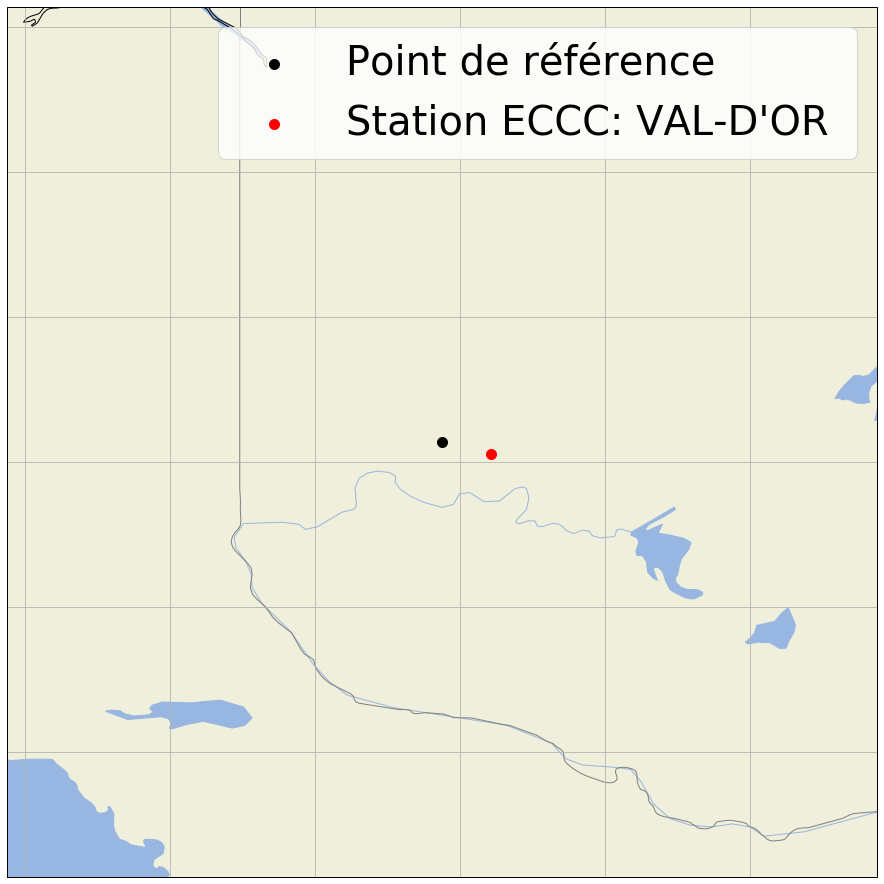

In [98]:
import numpy as np
import pandas as pd
import datetime
from datetime import date, timedelta
# Données de la station la plus proche: on veut 
yeari= 2010
monthi=1
yearf = 2017
monthf = 12
lati = 48.14
loni = -78.125

dataFrame_STATION, df_station = get_closed_station_precip(lati, loni, yeari, yearf)

print("####################")
print("La station suivant sera extraire: ")
df_station

lat_s = float(df_station.iloc[7].values)
lon_s = float(df_station.iloc[8].values)
dataFrame_STATION = dataFrame_STATION.loc[:,'variable'] 

grids_lat = []
grids_lon = []
grids_name = []
grids_lat.append(lati)
grids_lat.append(lat_s)

grids_lon.append(loni)
grids_lon.append(lon_s)

grids_name.append('Point de référence')
grids_name.append('Station ECCC: ' + df_station.iloc[1,0] )
plot_closed_points(grids_lat, grids_lon, grids_name, 'Precipitation')

In [99]:
df_station


,79
Prov,QC
nom de la station,VAL-D'OR
stnid,7098600
année déb.,1952
mois déb.,1
année fin.,2017
mois fin.,12
lat (deg),48.0564
long (deg),-77.7867
élév (m),337


In [111]:
dataFrame_STATION = dataFrame_STATION.replace(-9999.99, 0)
dataFrame_STATION

datetime
2010-01-01     4.76
2010-01-02     1.74
2010-01-03     2.16
2010-01-04     1.81
2010-01-05     0.76
2010-01-06     1.69
2010-01-07     0.46
2010-01-08     0.46
2010-01-09     0.00
2010-01-10     0.93
2010-01-11     0.23
2010-01-12     0.93
2010-01-13     0.55
2010-01-14     1.65
2010-01-15     0.81
2010-01-16     5.80
2010-01-17     0.51
2010-01-18     2.16
2010-01-19     2.55
2010-01-20     0.23
2010-01-21     0.21
2010-01-22     0.21
2010-01-23     0.00
2010-01-24     4.42
2010-01-25    18.27
2010-01-26     0.21
2010-01-27     6.03
2010-01-28     1.16
2010-01-29     0.21
2010-01-30     1.62
              ...  
2017-12-02     3.10
2017-12-03     0.46
2017-12-04    21.92
2017-12-05    12.53
2017-12-06     3.25
2017-12-07     1.86
2017-12-08    16.24
2017-12-09    16.24
2017-12-10     0.00
2017-12-11     3.02
2017-12-12     0.00
2017-12-13     0.46
2017-12-14     0.23
2017-12-15     2.55
2017-12-16     0.00
2017-12-17     0.00
2017-12-18     3.06
2017-12-19    10.67
2017-12-20 

In [112]:
dataFrame_STATION.to_csv('./'+grids_name[1].split()[2] + '_daily_prcp_' + str(yeari) + '_' + str(yearf) +'.csv', na_rep='NULL') 

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


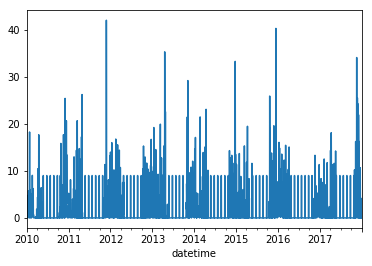

In [115]:
dataFrame_STATION.plot()